In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv(r"input/train.csv",dtype=np.float32)
target_numpy = train.label.values
feature_numpy = train.loc[:, train.columns != 'label'].values/255

In [3]:
features_train, features_test, targets_train, targets_test = (
    train_test_split(feature_numpy,target_numpy,test_size = 0.2,random_state = 42)) 

In [4]:
featureTrain = torch.from_numpy(features_train)
targetTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

In [5]:
featureTest = torch.from_numpy(features_test)
targetTest = torch.from_numpy(targets_test).type(torch.LongTensor)

In [23]:
batch_size = 100
n_iters = 100000
n_epochs = int(n_iters * batch_size / len(features_train))

In [7]:
train = torch.utils.data.TensorDataset(featureTrain,targetTrain)
test = torch.utils.data.TensorDataset(featureTest,targetTest)

trainloader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=False)
testloader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=False)

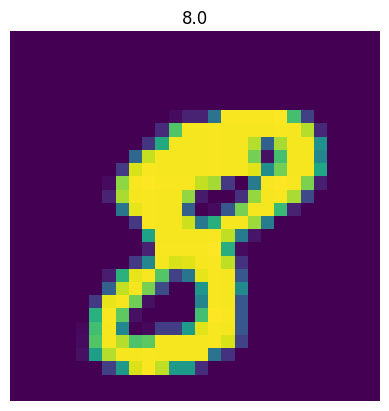

In [8]:
plt.imshow(feature_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(target_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [9]:
class Net(nn.Module):
    def __init__(self,in_dim,out_dim):
        super(Net,self).__init__()
        self.linear = nn.Linear(in_dim,out_dim)
        
    def forward(self,x):
        out = self.linear(x)
        return out
    

In [10]:
# in_dim = 28*28
# out_dim = 10
# # model2 = Net(in_dim = 28*28,out_dim = 10)
# da = torch.from_numpy(feature_numpy[10].reshape(28,28))
# model2 = nn.Linear(28*28,10,dtype=torch.uint8)
# model2(da)
# # model2(torch.from_numpy(feature_numpy[10].reshape(28,28)))

In [24]:
in_dim = 28*28
out_dim = 10
model = Net(in_dim = in_dim,out_dim = out_dim)
loss_func = nn.CrossEntropyLoss()
lr = 0.0001
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

In [25]:
cnt = 0
loss_list = []
iter_list = []
for epoch in range(n_epochs):
    for i,(images,labels) in enumerate(trainloader):
        train = Variable(images.view(-1,28*28))
        
        
        # print(train.shape)
        
        
        labels = Variable(labels)
        optimizer.zero_grad()
        out = model(train)
        loss = loss_func(out,labels)
        loss.backward()
        optimizer.step()
        cnt += 1
        
        if cnt % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in testloader: 
                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iter_list.append(cnt)
        if cnt % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(cnt, loss.data, accuracy))

Iteration: 500  Loss: 2.2559800148010254  Accuracy: 17.285715103149414%
Iteration: 1000  Loss: 2.226027727127075  Accuracy: 27.14285659790039%
Iteration: 1500  Loss: 2.1531460285186768  Accuracy: 36.35714340209961%
Iteration: 2000  Loss: 2.1273915767669678  Accuracy: 43.095237731933594%
Iteration: 2500  Loss: 2.0394434928894043  Accuracy: 49.904762268066406%
Iteration: 3000  Loss: 2.036301612854004  Accuracy: 55.154762268066406%
Iteration: 3500  Loss: 1.9759310483932495  Accuracy: 59.904762268066406%
Iteration: 4000  Loss: 1.9302140474319458  Accuracy: 62.9523811340332%
Iteration: 4500  Loss: 1.9722126722335815  Accuracy: 65.63095092773438%
Iteration: 5000  Loss: 1.8571085929870605  Accuracy: 67.58333587646484%
Iteration: 5500  Loss: 1.8459378480911255  Accuracy: 69.11904907226562%
Iteration: 6000  Loss: 1.8244858980178833  Accuracy: 70.3452377319336%
Iteration: 6500  Loss: 1.737288475036621  Accuracy: 71.38095092773438%
Iteration: 7000  Loss: 1.7410812377929688  Accuracy: 72.321426391

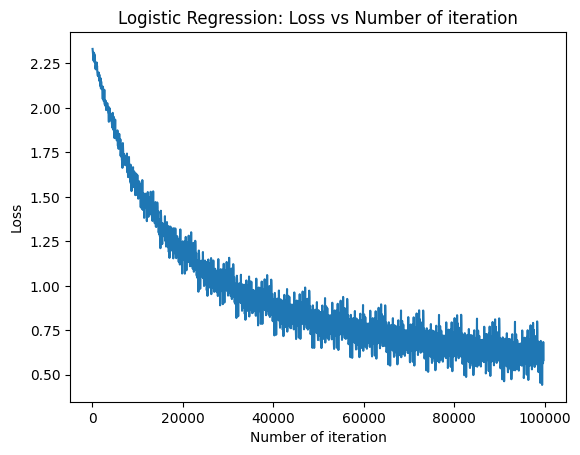

In [26]:
plt.plot(iter_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()